In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
from umap import UMAP
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_20newsgroups

import lda_functions
import bert_embed


In [8]:
newsgroups_data = fetch_20newsgroups(subset='all')

In [9]:
documents = newsgroups_data.data
print(len(documents))

18846


In [10]:
lda_trainer = lda_functions.LDAModelTrainer(documents)
processed_docs = lda_trainer.preprocess()

In [13]:
# Find optimal number of topics with metrics
eval_metrics = lda_trainer.find_optimal_topics(passes = 10, max_topics = 30, start = 5, step = 15)

2024-11-27 17:28:49,168 : INFO : using autotuned alpha, starting with [0.2, 0.2, 0.2, 0.2, 0.2]
2024-11-27 17:28:49,175 : INFO : using serial LDA version on this node
2024-11-27 17:28:49,200 : INFO : running online (multi-pass) LDA training, 5 topics, 10 passes over the supplied corpus of 18846 documents, updating model once every 2000 documents, evaluating perplexity every 18846 documents, iterating 50x with a convergence threshold of 0.001000
2024-11-27 17:28:49,200 : INFO : PROGRESS: pass 0, at document #2000/18846
2024-11-27 17:28:50,358 : INFO : optimized alpha [0.25881928, 0.23687595, 0.25954032, 0.30191025, 0.25482014]
2024-11-27 17:28:50,367 : INFO : merging changes from 2000 documents into a model of 18846 documents
2024-11-27 17:28:50,379 : INFO : topic #0 (0.259): 0.006*"would" + 0.005*"one" + 0.004*"use" + 0.004*"like" + 0.004*"article" + 0.004*"university" + 0.003*"get" + 0.003*"people" + 0.003*"know" + 0.003*"right"
2024-11-27 17:28:50,380 : INFO : topic #1 (0.237): 0.006

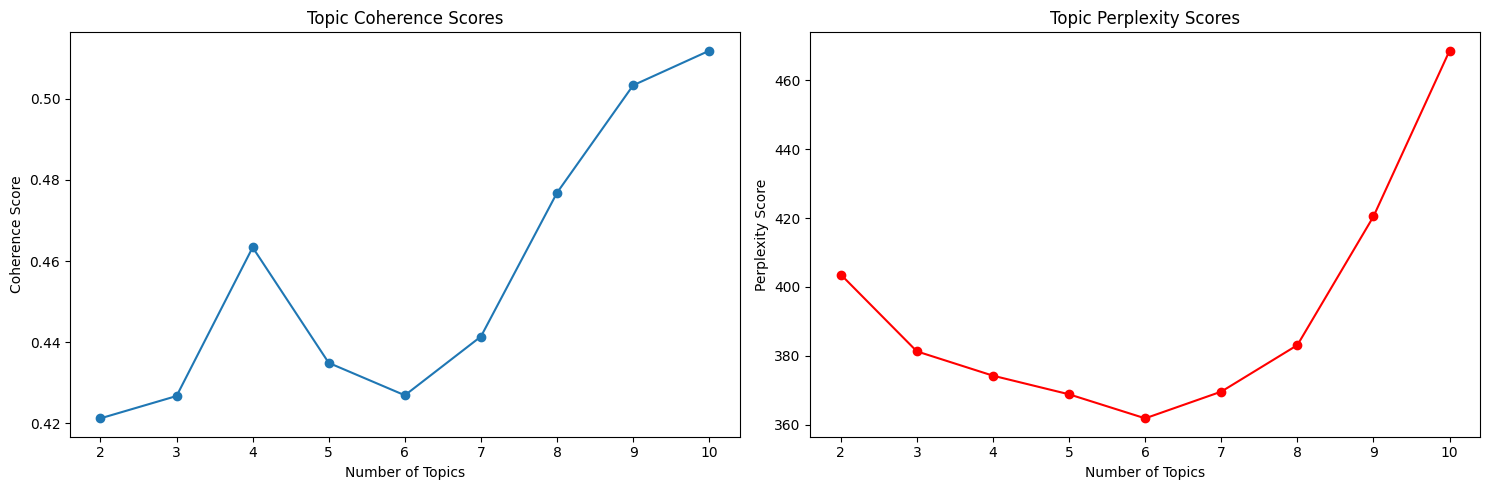

In [12]:
# Plot topic metrics
lda_trainer.plot_topic_metrics()

In [ ]:
# Get optimal number of topics
optimal_topics = lda_trainer.get_optimal_topics()
print(f"Optimal number of topics: {optimal_topics}")

In [ ]:
# Train final model with optimal topics
final_model = lda_trainer.train_lda_model(num_topics=optimal_topics, passes = 25)

In [ ]:
lda_trainer.print_topics()

In [ ]:
embedder = bert_embed.BertEmbedder()
embeddings = embedder.get_embeddings(documents)

In [ ]:
topic_assignment = lda_trainer.predict_topics()
topic_assignment = np.argmax(topic_assignment, axis = 1)

In [ ]:
plt.scatter(umap_embedding[:, 0], umap_embedding[:,1], c = topic_assignment)
plt.title('U-MAP Representations')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

In [ ]:
vector_similarities = calculate_similarities(embeddings)

In [ ]:
metric_list = []
correlation_list = []
similarities = np.zeros((len(documents), len(documents), 9))
for topic_num in range(2,10):
    print(topic_num)
    model = lda_trainer.train_lda_model(num_topics=topic_num, passes = 25)
    topic_assignment = lda_trainer.predict_topics()
    metrics = evaluate_clustering(np.argmax(topic_assignment, axis =1), umap_embedding)
    metric_list.append(metrics)
    similarities[:,:, topic_num - 2] = calculate_similarities(topic_assignment)
    correlations= analyze_correlation(vector_similarities, similarities[:,:, topic_num - 2])
    correlation_list.append(correlations)

In [ ]:
results = pd.DataFrame(metric_list)
results.index = range(2, 10)
results

In [ ]:
resultscorr = pd.DataFrame(correlation_list)
resultscorr.index = range(2, 10)
resultscorr

In [ ]:
# Plot performance metrics
plt.figure(figsize=(15, 5))
for i, metric in enumerate(['pearson_correlation', 'spearman_correlation', 'r_squared'], 1):
    plt.subplot(1, 3, i)
    sns.lineplot(data=resultscorr, x=resultscorr.index, y=metric, marker='o')
    plt.title(f'{metric}')
    plt.xlabel('Topic Number')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [ ]:
# Plot performance metrics
plt.figure(figsize=(15, 5))
for i, metric in enumerate(['silhouette_score', 'calinski_harabasz', 'davies_bouldin'], 1):
    plt.subplot(1, 3, i)
    sns.lineplot(data=results, x=results.index, y=metric, marker='o')
    plt.title(f'{metric}')
    plt.xlabel('Topic Number')
    plt.ylabel(metric)
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
